In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings as wrn
wrn.filterwarnings('ignore', category = DeprecationWarning) 
wrn.filterwarnings('ignore', category = FutureWarning) 
wrn.filterwarnings('ignore', category = UserWarning)
wrn.filterwarnings('ignore', category = RuntimeWarning)

In [530]:
train_df = pd.read_csv('D:/숙탯 2기/2022-여름-캐글/9565_hospital_data/train.csv')
test_df = pd.read_csv('D:/숙탯 2기/2022-여름-캐글/9565_hospital_data/test.csv')

# 1. Variable Correction

**label 값 수정 (주어진 조건대로)**

In [531]:
train_df['OC']=train_df['OC'].replace('open',1)
train_df['OC']=train_df['OC'].replace(' close',0)

**날짜 변수를 datetime 타입으로 변경하고 연도, 월 변수 추출**

In [532]:
train_df.openDate = pd.to_datetime(train_df.openDate.astype(str), format='%Y%m%d')
train_df.openDate.head()

0   2007-12-28
1   1997-04-01
2   2016-12-28
3   2000-08-14
4   2005-09-01
Name: openDate, dtype: datetime64[ns]

In [533]:
test_df.openDate = pd.to_datetime(test_df.openDate.astype(str), format='%Y%m%d')
test_df.openDate.head()

0   1998-11-25
1   2016-03-09
2   1989-04-27
3   2010-02-26
4   2004-06-04
Name: openDate, dtype: datetime64[ns]

In [534]:
train_df['Year'] = train_df['openDate'].dt.year
train_df['Month'] = train_df['openDate'].dt.month

test_df['Year'] = test_df['openDate'].dt.year
test_df['Month'] = test_df['openDate'].dt.month

In [535]:
test_df['Year'] = test_df['Year'].fillna(-1).astype('int64')
test_df['Year'] = test_df['Year'].replace(-1, 0)

test_df['Month'] = test_df['Month'].fillna(-1).astype('int64')
test_df['Month'] =test_df['Month'].replace(-1, 0)

**test data의 employee 인원 변수에서 콤마 삭제 & object에서 수치형으로 변환**

- '1,816' 등 콤마를 포함한 문자열로 인원수가 저장되어 있음.

In [536]:
test_df.employee1 = test_df.employee1.str.replace(',', '')
test_df.employee1 = pd.to_numeric(test_df.employee1, errors='ignore')

test_df.employee2 = test_df.employee2.str.replace(',', '')
test_df.employee2 = pd.to_numeric(test_df.employee2, errors='ignore')

# 2. Outlier Treatment

- 추후에 스케일링을 통해 해결하도록 한다.

# 3. Handling Missing Values

### 3.1 결측치가 50% 이상인 열 제거

In [537]:
# 열 제거 

train_df = train_df.drop(columns=['receivableL2', 'receivableL1', 'surplus2', 'surplus1'])
test_df = test_df.drop(columns=['receivableL2', 'receivableL1', 'surplus2', 'surplus1'])

### 3.2 Imputation  
### 3.2.1 Numerical Features

- MICE 방법 사용. 선형회귀모델을 기반으로 여러 차례 반복하여 결측값을 도출
- Reference: https://www.numpyninja.com/post/how-to-implement-mice-algorithm-using-iterative-imputer-to-handle-missing-values

In [538]:
train_num = train_df.select_dtypes(include = ['float64'])
test_num = test_df.select_dtypes(include = ['float64']).drop('OC', axis=1)

train_num.replace(0, np.nan, inplace=True)
test_num.replace(0, np.nan, inplace=True)

In [539]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
MICE_imputer = IterativeImputer(estimator=lr, max_iter=30, verbose=2, tol=1e-5, imputation_order='roman')

train_mice = MICE_imputer.fit_transform(train_num)
test_mice = MICE_imputer.transform(test_num)

[IterativeImputer] Completing matrix with shape (301, 47)
[IterativeImputer] Ending imputation round 1/30, elapsed time 0.18
[IterativeImputer] Change: 427471277573.1162, scaled tolerance: 1640000.0000000002 
[IterativeImputer] Ending imputation round 2/30, elapsed time 0.33
[IterativeImputer] Change: 772047739166.2233, scaled tolerance: 1640000.0000000002 
[IterativeImputer] Ending imputation round 3/30, elapsed time 0.50
[IterativeImputer] Change: 839042699101.1716, scaled tolerance: 1640000.0000000002 
[IterativeImputer] Ending imputation round 4/30, elapsed time 0.68
[IterativeImputer] Change: 369851553488.84216, scaled tolerance: 1640000.0000000002 
[IterativeImputer] Ending imputation round 5/30, elapsed time 0.84
[IterativeImputer] Change: 188151525900.46625, scaled tolerance: 1640000.0000000002 
[IterativeImputer] Ending imputation round 6/30, elapsed time 0.99
[IterativeImputer] Change: 43002771159.645546, scaled tolerance: 1640000.0000000002 
[IterativeImputer] Ending imputat

In [540]:
# imputer로 결측치 대체하면 numpy array가 되므로 다시 데이터프레임으로 변환.

train_mice = pd.DataFrame(train_mice)
train_mice.columns = train_num.columns

test_mice = pd.DataFrame(test_mice)
test_mice.columns = test_num.columns

for col in train_mice.columns:
    train_df[col] = train_mice[col]
    test_df[col] = test_mice[col]     # 변환한 값 덮어쓰기

In [541]:
print(train_df[train_df.bedCount < 0].index)
print(train_df[train_df.employee1 < 0].index)
print(train_df[train_df.employee2 < 0].index)
print()
print(test_df[test_df.bedCount < 0].index)
print(test_df[test_df.employee1 < 0].index)
print(test_df[test_df.employee2 < 0].index)

Int64Index([39, 237, 245], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')

Int64Index([78, 125], dtype='int64')
Int64Index([88], dtype='int64')
Int64Index([], dtype='int64')


In [542]:
# 0으로 변경

train_df.loc[[39, 237, 245], 'bedCount'] = 0
print(train_df[train_df.bedCount < 0].index)

test_df.loc[[78, 125], 'bedCount'] = 0
print(test_df[test_df.bedCount < 0].index)

test_df.loc[88, 'employee1'] = 0
print(test_df[test_df.employee1 < 0].index)

Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')


### 3.2.2 Categorical Features

- 최빈값 대체
- Datawig 방법 사용하려 했는데 패키지 설치 실패
    + Datawig: DNN(Deep Neural Network)으로 누락된 값을 유추하는 방법.
- MICE 방법 사용하고 estimator를 random forest classifier로 하려 했는데 에러가 해결되지 않아서 다른 방법을 선택하였음.

In [543]:
train_df['instkind'].fillna(train_df.instkind.mode()[0], inplace=True)
test_df['instkind'].fillna(test_df.instkind.mode()[0], inplace=True)

train_df['ownerChange'].fillna(train_df.ownerChange.mode()[0], inplace=True)
test_df['ownerChange'].fillna(test_df.ownerChange.mode()[0], inplace=True)

In [544]:
# from sklearn.ensemble import RandomForestClassifier
# # from sklearn.tree import DecisionTreeClassifier

# train_df['instkind'] = train_df.instkind.astype('category')
# test_df['instkind'] = test_df.instkind.astype('category')

# train_df['ownerChange'] = train_df.ownerChange.astype('category')
# test_df['ownerChange'] = test_df.ownerChange.astype('category')

# rf = RandomForestClassifier()
# rf_imputer = IterativeImputer(estimator=rf, max_iter=30, verbose=2, tol=1e-5, imputation_order='roman')

# train_knn = rf_imputer.fit_transform(train_df.drop(['OC'], axis=1))
# test_knn = rf_imputer.transform(test_df.drop(['OC'], axis=1))

In [545]:
train_df.isnull().any().sum(), test_df.isnull().any().sum(), 

(0, 2)

- test data: OC(target variable), openDate(버릴 변수)

# 4. Data transformation

### 4.1 Feature Selection

### 4.1.1 Information Gain

- 한 변수를 기준으로 데이터셋을 나눌 때, 타겟 변수에 대한 분류의 정도가 얼마나 변하는지를 보여주는 지표. (불순물이 없이 정확하게 되는지.) 
>ex)  
원 데이터는 레이블 간의 비율이 7:3으로 섞여 있었음.  
    A 변수를 기준으로 나누자 A>1인 데이터셋에는 레이블 0만, A <= 1인 데이터셋에는 레이블 1만 있게 되었음.  
    --> A 변수가 데이터셋의 불순도(entropy)를 낮춘 것임. (information gain이 큰 변수임)

- 함수 코드) https://www.featureranking.com/tutorials/machine-learning-tutorials/information-gain-computation/

In [508]:
def compute_entropy(feature):
    """
    This function calculates entropy of a feature.
    """
    probs = feature.value_counts(normalize=True)
    entropy = -1 * np.sum(np.log2(probs) * probs)
        
    return(round(entropy, 3))


def comp_feature_information_gain(df, target, descriptive_feature):
    """
    This function calculates information gain for splitting on 
    a particular descriptive feature for a given dataset
    """
    
#     print('target feature:', target)
#     print('descriptive_feature:', descriptive_feature)
            
    target_entropy = compute_entropy(df[target])

    # we define two lists below:
    # entropy_list to store the entropy of each partition
    # weight_list to store the relative number of observations in each partition
    entropy_list = list()
    weight_list = list()
    
    # loop over each level of the descriptive feature
    # to partition the dataset with respect to that level
    # and compute the entropy and the weight of the level's partition
    for level in df[descriptive_feature].unique():
        df_feature_level = df[df[descriptive_feature] == level]
        entropy_level = compute_entropy(df_feature_level[target])
        entropy_list.append(round(entropy_level, 3))
        weight_level = len(df_feature_level) / len(df)
        weight_list.append(round(weight_level, 3))

    feature_remaining_impurity = np.sum(np.array(entropy_list) * np.array(weight_list))
#     print('remaining impurity:', feature_remaining_impurity)
    
    information_gain = target_entropy - feature_remaining_impurity
#     print('information gain:', information_gain)
    
#     print('====================')

    return(information_gain)

In [182]:
ig = pd.DataFrame({'feature':[], 'IG':[]})

for i, col in enumerate(train_df.drop(['OC', 'inst_id'], axis=1).columns):
    ig.loc[i, 'feature'] = col
    ig.loc[i, 'IG'] = comp_feature_information_gain(train_df, 'OC', col)

ig = ig.set_index('feature')
ig.sort_values(by='IG', ascending=False)

,IG
feature,
openDate,0.279000
receivableS1,0.272000
longLoan2,0.272000
receivableS2,0.272000
longLoan1,0.265000
ctax2,0.265000
liquidAsset2,0.265000
netAsset1,0.265000
quickAsset2,0.265000


### 4.1.2 RFE / RFECV

- RFE(Recursive Feature Elimination) : 몇 개 변수 택할지 설정해야 함
- RFECV (Recursive Feature Elimination with Cross Validation) : 교차 검증 거쳐 알아서 변수 선택해줌

1) RFE

In [225]:
from sklearn.datasets import make_classification
from sklearn.feature_selection import RFE, RFECV
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt

In [229]:
X, y = make_classification(n_samples=301, n_features=56, random_state=1234)
display(X.shape, y.shape)

(301, 56)

(301,)

RFECV (Recursive Feature Elimination with Cross Validation)

In [245]:
clf = LGBMClassifier(random_state=1234, n_estimators=100, learning_rate=0.01)
min_features_to_select = 15
step = 3
selector = RFECV(clf, step=step, cv=5, min_features_to_select=min_features_to_select)
selector = selector.fit(X, y)

In [247]:
for i, b in enumerate(selector.support_):
    print(i, ':', b, end=',  ')
    if i % 4 == 3:
        print()

0 : True,  1 : False,  2 : True,  3 : False,  
4 : False,  5 : False,  6 : True,  7 : False,  
8 : True,  9 : False,  10 : False,  11 : True,  
12 : False,  13 : False,  14 : False,  15 : False,  
16 : False,  17 : False,  18 : False,  19 : False,  
20 : False,  21 : False,  22 : False,  23 : False,  
24 : False,  25 : False,  26 : True,  27 : True,  
28 : True,  29 : False,  30 : False,  31 : True,  
32 : True,  33 : False,  34 : False,  35 : False,  
36 : False,  37 : False,  38 : False,  39 : True,  
40 : True,  41 : False,  42 : False,  43 : False,  
44 : False,  45 : True,  46 : True,  47 : False,  
48 : True,  49 : False,  50 : False,  51 : False,  
52 : False,  53 : False,  54 : False,  55 : False,  


sido / instkind / salescost1 / noi1 / longLoan1 / netAsset1 / sga2 / salary2 / quickAsset2 / receivableS2 /   
debt2 / liquidLiabilities2 /  NCLiabilities2

* RFE로 해도 동일 결과 얻음.

**결론) sgg, year, month, ownerchange, employee 버리기** 

In [546]:
train_df.drop(['sgg', 'Year', 'Month', 'ownerChange', 'employee1', 'employee2'], axis=1, inplace=True)
test_df.drop(['sgg', 'Year', 'Month', 'ownerChange', 'employee1', 'employee2'], axis=1, inplace=True)

### 4.2 Discreditization + etc

1) bedCount 변수

In [547]:
condition1 = train_df['bedCount'] <= 29
condition2 = (train_df['bedCount'] >= 30) & (train_df['bedCount'] < 100)
condition3 = (train_df['bedCount'] >= 100) & (train_df['bedCount'] <= 300)
condition4 = train_df['bedCount'] >= 300

In [548]:
train_df.loc[condition1, 'bedCount'] = 1
train_df.loc[condition2, 'bedCount'] = 2
train_df.loc[condition3, 'bedCount'] = 3
train_df.loc[condition4, 'bedCount'] = 4

In [549]:
condition1 = test_df['bedCount'] <= 29
condition2 = (test_df['bedCount'] >= 30) & (test_df['bedCount'] < 100)
condition3 = (test_df['bedCount'] >= 100) & (test_df['bedCount'] <= 300)
condition4 = test_df['bedCount'] >= 300

In [550]:
test_df.loc[condition1, 'bedCount'] = 1
test_df.loc[condition2, 'bedCount'] = 2
test_df.loc[condition3, 'bedCount'] = 3
test_df.loc[condition4, 'bedCount'] = 4

2) 도시권 구분을 따라 sido 변수 내 범주 병합

In [551]:
change_value_dict = {'seoul':'Seoul', 'gyeonggi':'Seoul', 'incheon':'Seoul',     # 수도권
                    'choongbuk':'Daejeon', 'choongnam':'Daejeon', 'daejeon':'Daejeon', 'sejong':'Daejeon',   # 대전권
                    'gwangju':'Gwangju', 'jeonnam':'Gwangju',    # 광주권
                    'daegu':'Daegu', 'gyeongbuk':'Daegu',     # 대구권
                    'busan':'Busan', 'ulsan':'Busan', 'gyeongnam':'Busan',     # 부산권
                    'gangwon':'etc', 'jeonbuk':'etc', 'jeju':'etc'}    # 기타


train_df['Metro'] = train_df['sido']
test_df['Metro'] = test_df['sido']
train_df = train_df.replace({'Metro':change_value_dict})
test_df = test_df.replace({'Metro':change_value_dict})

In [552]:
train_df.drop('sido', axis=1, inplace=True)
test_df.drop('sido', axis=1, inplace=True)

### 4.3 변수 타입 변환

In [553]:
def new_type(df, feature, dtype):
    df[feature] = df[feature].astype(dtype)

In [554]:
# train data

for col in ['OC', 'instkind', 'Metro']:
    new_type(train_df, col, 'category')
    
new_type(train_df, 'bedCount', 'int64')
new_type(train_df, 'bedCount', 'category')

In [555]:
# test data

for col in ['OC', 'instkind', 'Metro']:
    new_type(test_df, col, 'category')
    
new_type(test_df, 'bedCount', 'int64')
new_type(test_df, 'bedCount', 'category')

In [578]:
train_df.instkind

0          nursing_hospital
1          general_hospital
2          nursing_hospital
3          general_hospital
4          general_hospital
               ...         
296        nursing_hospital
297                hospital
298                hospital
299        nursing_hospital
300    traditional_hospital
Name: instkind, Length: 301, dtype: category
Categories (7, object): ['clinic', 'dental_clinic', 'general_hospital', 'hospital', 'nursing_hospital', 'traditional_clinic', 'traditional_hospital']

### 4.4 Scaling and Normalizing

### 4.4.1 로그 변환 후 Robust Scaling

In [556]:
train_df.drop('openDate', axis=1, inplace=True)
test_df.drop('openDate', axis=1, inplace=True)

In [557]:
# log_tr = np.log1p(train_df.select_dtypes(include = ['float64', 'int64'])).drop('inst_id', axis=1)
# log_te = np.log1p(test_df.select_dtypes(include = ['float64', 'int64'])).drop('inst_id', axis=1)

- 로그 변환하면 결측치가 대거 발생함

In [579]:
numerics = train_df.select_dtypes(include = ['float64', 'int64']).drop('inst_id', axis=1).columns

from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
train_robust = scaler.fit_transform(train_df.loc[:, numerics])
test_robust = scaler.transform(train_df.loc[:, numerics])

train_robust = pd.DataFrame(train_robust, columns = numerics)
test_robust = pd.DataFrame(test_robust, columns = numerics)

tr = train_df.copy()
te = test_df.copy()

for col in train_robust.columns:
    tr[col] = train_robust[col]
    te[col] = test_robust[col]

In [587]:
tr.isna().sum().any(), te.isna().sum().any()

(False, True)

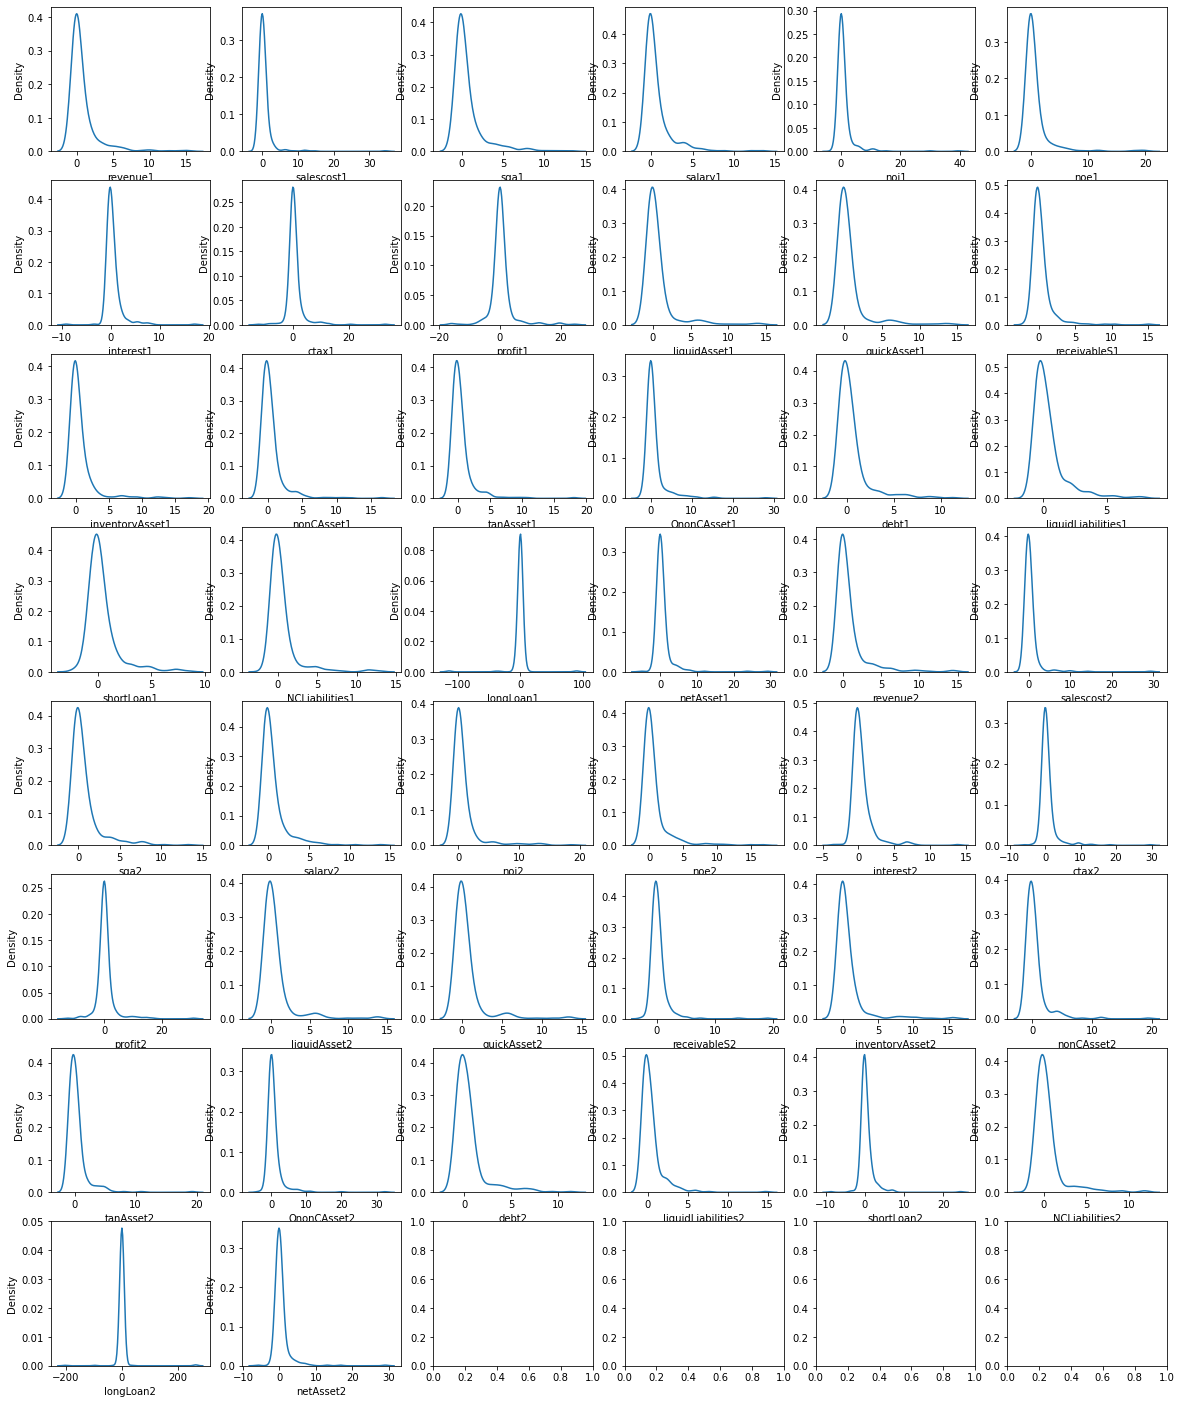

In [583]:
col_n = 6
row_n = 8

fig, ax = plt.subplots(ncols=col_n, nrows=row_n, figsize=(20,25))

for i, col in enumerate(numerics):
    sns.kdeplot(x=tr[col], ax=ax[int(i/col_n),int(i%col_n)])

**결론) 로그 변환하면 결측치가 대거 발생해서 로그 변환 없이 스케일링만 한 데이터로 채택**

In [589]:
tr_copy = train_df.copy()  # 백업
te_copy = test_df.copy()

train_df = tr
test_df = te


# 5. 파생변수 생성

### 5.1 2개년 평균 재무제표 열 생성

In [592]:
def average(df, col1, col2):
    col_name = col1[:-1]
    df[col_name] = (df[col1]+df[col2])/2

In [593]:
from itertools import combinations

for columns in list(combinations(train_df.columns, 2)):
    if columns[0][:-1] == columns[1][:-1]:
        average(train_df, columns[0], columns[1])

In [594]:
for columns in list(combinations(test_df.columns, 2)):
    if columns[0][:-1] == columns[1][:-1]:
        average(test_df, columns[0], columns[1])

In [600]:
train_df.drop(['revenue1', 'salescost1',
       'sga1', 'salary1', 'noi1', 'noe1', 'interest1', 'ctax1', 'profit1',
       'liquidAsset1', 'quickAsset1', 'receivableS1', 'inventoryAsset1',
       'nonCAsset1', 'tanAsset1', 'OnonCAsset1', 'debt1', 'liquidLiabilities1',
       'shortLoan1', 'NCLiabilities1', 'longLoan1', 'netAsset1', 'revenue2',
       'salescost2', 'sga2', 'salary2', 'noi2', 'noe2', 'interest2', 'ctax2',
       'profit2', 'liquidAsset2', 'quickAsset2', 'receivableS2',
       'inventoryAsset2', 'nonCAsset2', 'tanAsset2', 'OnonCAsset2', 'debt2',
       'liquidLiabilities2', 'shortLoan2', 'NCLiabilities2', 'longLoan2',
       'netAsset2'], axis = 1, inplace=True)

test_df.drop(['revenue1', 'salescost1',
       'sga1', 'salary1', 'noi1', 'noe1', 'interest1', 'ctax1', 'profit1',
       'liquidAsset1', 'quickAsset1', 'receivableS1', 'inventoryAsset1',
       'nonCAsset1', 'tanAsset1', 'OnonCAsset1', 'debt1', 'liquidLiabilities1',
       'shortLoan1', 'NCLiabilities1', 'longLoan1', 'netAsset1', 'revenue2',
       'salescost2', 'sga2', 'salary2', 'noi2', 'noe2', 'interest2', 'ctax2',
       'profit2', 'liquidAsset2', 'quickAsset2', 'receivableS2',
       'inventoryAsset2', 'nonCAsset2', 'tanAsset2', 'OnonCAsset2', 'debt2',
       'liquidLiabilities2', 'shortLoan2', 'NCLiabilities2', 'longLoan2',
       'netAsset2'], axis = 1, inplace=True)

### 5.2 주요 재무지표 열 생성

In [610]:
# 안정성
train_df['solvency'] = (train_df['liquidAsset'] - train_df['liquidLiabilities'])*100   # 지급 능력
train_df['current_ratio'] = (train_df['liquidAsset'] / train_df['liquidLiabilities'])*100    # 유동비율
train_df['debt_ratio'] = (train_df['debt']/train_df['netAsset'])*100    # 부채 비율
train_df['car'] = (train_df['netAsset']/(train_df['debt']+train_df['netAsset']))*100    # 자기자본비율
train_df['icr'] = ((train_df['revenue']-train_df['salescost']-train_df['sga'])/train_df['interest'])*100   # 영업이익 대비 이자 보상 비율

# 수익성
train_df['opr'] = ((train_df['revenue']-train_df['salescost']-train_df['sga'])/train_df['revenue'])*100    # 매출액영업 이익율
train_df['ros'] = (train_df['profit']/train_df['revenue'])*100    # 매출액 순이익률
train_df['roa'] = (train_df['profit']/(train_df['debt']+train_df['netAsset']))*100   # 총자산 순이익률
train_df['roe'] = (train_df['profit']/train_df['netAsset'])*100   # 자기자본 순이익률

# 성장성 및 활동성: 전년도 대비 올해 지표

In [613]:
# 안정성
test_df['solvency'] = (test_df['liquidAsset'] - test_df['liquidLiabilities'])*100   # 지급 능력
test_df['current_ratio'] = (test_df['liquidAsset'] / test_df['liquidLiabilities'])*100    # 유동비율
test_df['debt_ratio'] = (test_df['debt']/test_df['netAsset'])*100    # 부채 비율
test_df['car'] = (test_df['netAsset']/(test_df['debt']+test_df['netAsset']))*100    # 자기자본비율
test_df['icr'] = ((test_df['revenue']-test_df['salescost']-test_df['sga'])/test_df['interest'])*100   # 영업이익 대비 이자 보상 비율

# 수익성
test_df['opr'] = ((test_df['revenue']-test_df['salescost']-test_df['sga'])/test_df['revenue'])*100    # 매출액영업 이익율
test_df['ros'] = (test_df['profit']/test_df['revenue'])*100    # 매출액 순이익률
test_df['roa'] = (test_df['profit']/(test_df['debt']+test_df['netAsset']))*100   # 총자산 순이익률
test_df['roe'] = (test_df['profit']/test_df['netAsset'])*100   # 자기자본 순이익률

# 성장성 및 활동성

# - 아 이거 스케일링 안 했다

In [611]:
ig = pd.DataFrame({'feature':[], 'IG':[]})

for i, col in enumerate(train_df.drop(['OC', 'inst_id'], axis=1).columns):
    ig.loc[i, 'feature'] = col
    ig.loc[i, 'IG'] = comp_feature_information_gain(train_df, 'OC', col)

ig = ig.set_index('feature')
ig.sort_values(by='IG', ascending=False)

,IG
feature,
longLoan,0.272000
receivableS,0.272000
tanAsset,0.265000
nonCAsset,0.265000
roa,0.265000
car,0.265000
debt_ratio,0.265000
current_ratio,0.265000
solvency,0.265000


In [615]:
X, y = make_classification(n_samples=301, n_features=36, random_state=1234)
display(X.shape, y.shape)

(301, 36)

(301,)

In [616]:
clf = LGBMClassifier(random_state=1234, n_estimators=100, learning_rate=0.01)
min_features_to_select = 15
step = 3
selector = RFECV(clf, step=step, cv=5, min_features_to_select=min_features_to_select)
selector = selector.fit(X, y)

In [622]:
for i, b in enumerate(selector.support_):
    print(i, ':', b, end=',  ')
    if i % 4 == 3:
        print()

0 : False,  1 : False,  2 : False,  3 : True,  
4 : False,  5 : False,  6 : False,  7 : False,  
8 : True,  9 : False,  10 : True,  11 : True,  
12 : False,  13 : False,  14 : False,  15 : False,  
16 : False,  17 : False,  18 : True,  19 : True,  
20 : True,  21 : False,  22 : False,  23 : True,  
24 : False,  25 : True,  26 : False,  27 : True,  
28 : False,  29 : False,  30 : False,  31 : True,  
32 : True,  33 : True,  34 : True,  35 : True,  


In [620]:
for i, col in enumerate(train_df.columns):
    print(i, ':', col, end=',  ')
    if i % 4 == 3:
        print()

0 : inst_id,  1 : OC,  2 : bedCount,  3 : instkind,  
4 : Metro,  5 : revenue,  6 : salescost,  7 : sga,  
8 : salary,  9 : noi,  10 : noe,  11 : interest,  
12 : ctax,  13 : profit,  14 : liquidAsset,  15 : quickAsset,  
16 : receivableS,  17 : inventoryAsset,  18 : nonCAsset,  19 : tanAsset,  
20 : OnonCAsset,  21 : debt,  22 : liquidLiabilities,  23 : shortLoan,  
24 : NCLiabilities,  25 : longLoan,  26 : netAsset,  27 : solvency,  
28 : current_ratio,  29 : debt_ratio,  30 : car,  31 : icr,  
32 : opr,  33 : ros,  34 : roa,  35 : roe,  


- instkind, salary, noe, nonCAsset, tanAsset, OnonCAsset, shortLoan, longLoan, solvency, icr, opr, ros, roa, roe

**최종 변수 선택)**  
instkind, longLoan, receivableS, nonCAsset, roa, car, debt_ratio, current_ratio, solvency, shortLoan, roe, ros, opr, icr, salary, noi, noe  
- 변수 선택 기준: information gain과 RFE 방법에서 모두 상위로 랭크된 변수 우선, 여러 개념을 포괄하고 있는 의미상 상위 개념 우선으로 택하였음

** 아까 숫자로 형변환 안 한 범주형 변수들 처리

In [649]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_df['instkind'] = le.fit_transform(train_df['instkind'])
test_df['instkind'] = le.transform(test_df['instkind'])

In [651]:
encoder = LabelEncoder()

train_df['Metro'] = encoder.fit_transform(train_df['Metro'])
test_df['Metro'] = encoder.transform(test_df['Metro'])

In [652]:
train_df = train_df.set_index('inst_id')
test_df = test_df.set_index('inst_id')

# 6. Oversampling

In [654]:
features = ['instkind', 'longLoan', 'receivableS', 'nonCAsset', 'roa', 'car', 'debt_ratio', 'current_ratio',
            'solvency', 'shortLoan', 'roe', 'ros', 'opr', 'icr', 'salary', 'noi', 'noe']

train_final = train_df.loc[:, features]
y_train = train_df.OC

In [655]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_tr_over, y_train_over = smote.fit_resample(train_final, y_train)

print('before oversampling')
print('train feature set:', train_final.shape, 'train label set:', y_train.shape, '\n')

print('after oversampling')
print('train feature set:', X_tr_over.shape, 'train label set:', y_train_over.shape, '\n')
print('Distribution of labels :\n',pd.Series(y_train_over).value_counts() )

before oversampling
train feature set: (301, 17) train label set: (301,) 

after oversampling
train feature set: (572, 17) train label set: (572,) 

Distribution of labels :
 0    286
1    286
Name: OC, dtype: int64


In [656]:
from sklearn.model_selection import train_test_split, cross_val_score

X_train, X_val, y_train, y_val = train_test_split(X_tr_over, y_train_over, test_size=0.4, random_state=0)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(343, 17) (343,)
(229, 17) (229,)


In [688]:
y_val.value_counts()

0    119
1    110
Name: OC, dtype: int64

## 성능 확인

**1) DecisionTreeClassifier**

In [657]:
from sklearn.tree import DecisionTreeClassifier
from dmba import plotDecisionTree, classificationSummary

ClassTree = DecisionTreeClassifier(min_samples_leaf=50, max_depth=7)
ClassTree.fit(X_train, y_train)
classificationSummary(y_train, ClassTree.predict(X_train))
classificationSummary(y_val, ClassTree.predict(X_val))

Confusion Matrix (Accuracy 0.7872)

       Prediction
Actual   0   1
     0 137  30
     1  43 133
Confusion Matrix (Accuracy 0.7555)

       Prediction
Actual  0  1
     0 94 25
     1 31 79


In [659]:
from sklearn.metrics import classification_report
print(classification_report(y_val, ClassTree.predict(X_val)))

              precision    recall  f1-score   support

           0       0.75      0.79      0.77       119
           1       0.76      0.72      0.74       110

    accuracy                           0.76       229
   macro avg       0.76      0.75      0.75       229
weighted avg       0.76      0.76      0.76       229



**2) Logistic Regression**

In [660]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)

print(model.score(X_train, y_train))
print(model.score(X_val, y_val))

0.6880466472303207
0.6681222707423581


In [662]:
from sklearn.metrics import classification_report
print(classification_report(y_val, model.predict(X_val)))

              precision    recall  f1-score   support

           0       0.71      0.61      0.66       119
           1       0.63      0.73      0.68       110

    accuracy                           0.67       229
   macro avg       0.67      0.67      0.67       229
weighted avg       0.67      0.67      0.67       229



**cf) 변수 선택 없이**

In [674]:
train_final2 = train_df.drop(['OC', 'bedCount'], axis=1)
y_train = train_df.OC

smote = SMOTE(random_state=42)
X_tr_over2, y_train_over = smote.fit_resample(train_final2, y_train)

print('before oversampling')
print('train feature set:', train_final2.shape, 'train label set:', y_train.shape, '\n')

print('after oversampling')
print('train feature set:', X_tr_over2.shape, 'train label set:', y_train_over.shape, '\n')
print('Distribution of labels :\n',pd.Series(y_train_over).value_counts())


X_train2, X_val2, y_train, y_val = train_test_split(X_tr_over2, y_train_over, test_size=0.4, random_state=0)

print(X_train2.shape, y_train.shape)
print(X_val2.shape, y_val.shape)

before oversampling
train feature set: (301, 33) train label set: (301,) 

after oversampling
train feature set: (572, 33) train label set: (572,) 

Distribution of labels :
 0    286
1    286
Name: OC, dtype: int64
(343, 33) (343,)
(229, 33) (229,)


**1) DecisionTreeClassifier**

In [676]:
ClassTree = DecisionTreeClassifier(min_samples_leaf=50, max_depth=7)
ClassTree.fit(X_train2, y_train)
classificationSummary(y_train, ClassTree.predict(X_train2))
classificationSummary(y_val, ClassTree.predict(X_val2))

Confusion Matrix (Accuracy 0.7580)

       Prediction
Actual   0   1
     0 102  65
     1  18 158
Confusion Matrix (Accuracy 0.7293)

       Prediction
Actual  0  1
     0 69 50
     1 12 98


In [679]:
from sklearn.metrics import classification_report
print(classification_report(y_val, ClassTree.predict(X_val2)))

              precision    recall  f1-score   support

           0       0.85      0.58      0.69       119
           1       0.66      0.89      0.76       110

    accuracy                           0.73       229
   macro avg       0.76      0.74      0.72       229
weighted avg       0.76      0.73      0.72       229



**2) Logistic Regression**

In [680]:
model = LogisticRegression()
model.fit(X_train2, y_train)

print(model.score(X_train2, y_train))
print(model.score(X_val2, y_val))

0.760932944606414
0.7336244541484717


In [682]:
print(classification_report(y_val, model.predict(X_val2)))

              precision    recall  f1-score   support

           0       0.74      0.76      0.75       119
           1       0.73      0.71      0.72       110

    accuracy                           0.73       229
   macro avg       0.73      0.73      0.73       229
weighted avg       0.73      0.73      0.73       229

